In [1]:
import numpy as np 
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam


2024-11-14 12:41:17.715288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 12:41:23.826894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731584486.028363   74819 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731584486.531663   74819 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 12:41:31.052179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
def preprocess_data(data, labels):
    data = data / 255.0

    if len(data.shape) == 3:
        data = data.reshape(-1, data.shape[1], data.shape[2], 1)

    fractional_hours = (labels[:, 0]) + labels[:, 1] / 60.0

    labels_processed = fractional_hours
    
    data_train, data_temp, labels_train, labels_temp = train_test_split(
        data, labels_processed, test_size=0.2, random_state=42, shuffle=True
    )
    data_val, data_test, labels_val, labels_test = train_test_split(
        data_temp, labels_temp, test_size=0.5, random_state=42
    )
    return data_train, labels_train, data_test, labels_test, data_val, labels_val


def common_sense_loss(y_true, y_pred):
    y_pred = tf.math.mod(y_pred, 12)
    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12 - linear_diff)
    
    return tf.reduce_mean(tf.square(circular_diff))

def common_sense_metric(y_true, y_pred):
    y_pred = tf.math.mod(y_pred, 12)
    linear_diff = tf.abs(y_true - y_pred)
    circular_diff = tf.minimum(linear_diff, 12 - linear_diff)

    return tf.reduce_mean(circular_diff)


def format_error_in_hours_and_minutes(error_in_hours):
    hours = int(error_in_hours)
    minutes = int((error_in_hours - hours) * 60)
    return f"{hours} hours and {minutes} minutes"


def plot_training_validation_mae(history):
    train_mae = history.history['common_sense_metric']
    val_mae = history.history['val_common_sense_metric']
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_mae, label='Training MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean absolute error (hours)')
    plt.title('Training and validation mean absolute error')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_error_distribution(y_true, y_pred, num_bins=30):
    y_true = y_true   
    y_pred = y_pred.ravel() 
    y_pred = np.mod(y_pred, 12)

    linear_diff = np.abs(y_true - y_pred)
    circular_error = np.minimum(linear_diff, 12 - linear_diff)

    for i in range(len(y_true)):
        print(f"y_true: {y_true[i]}, y_pred: {y_pred[i]}, linear_diff: {linear_diff[i]}, circular_error: {circular_error[i]}")

    plt.figure(figsize=(10, 6))
    plt.hist(circular_error, bins=num_bins, color='skyblue', edgecolor='black')
    plt.title('Distribution of mean absolute errors')
    plt.xlabel('Mean absolute error (hours)')
    plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

    # Statistics of the error distribution
    mean_error_formatted = format_error_in_hours_and_minutes(np.mean(circular_error))
    median_error_formatted = format_error_in_hours_and_minutes(np.median(circular_error))
    max_error_formatted = format_error_in_hours_and_minutes(np.max(circular_error))

    print(f"Mean Error: {mean_error_formatted}")
    print(f"Median Error: {median_error_formatted}")
    print(f"Max Error: {max_error_formatted}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,713 (655.13 KB)

 Trainable params: 167,713 (655.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - common_sense_metric: 3.0059 - loss: 12.0321 - val_common_sense_metric: 3.0485 - val_loss: 12.2739
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9862 - loss: 11.8722 - val_common_sense_metric: 3.0453 - val_loss: 12.1940
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9921 - loss: 11.7184 - val_common_sense_metric: 3.0211 - val_loss: 10.8279
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9936 - loss: 9.9938 - val_common_sense_metric: 3.0024 - val_loss: 8.7826
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9698 - loss: 8.2668 - val_common_sense_metric: 2.9931 - val_loss: 7.7901
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9790 - loss: 7.3280 - val_common_sense_metric: 2.9820 - val_loss: 6.7856
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - common_sense_metric: 2.9702 - los

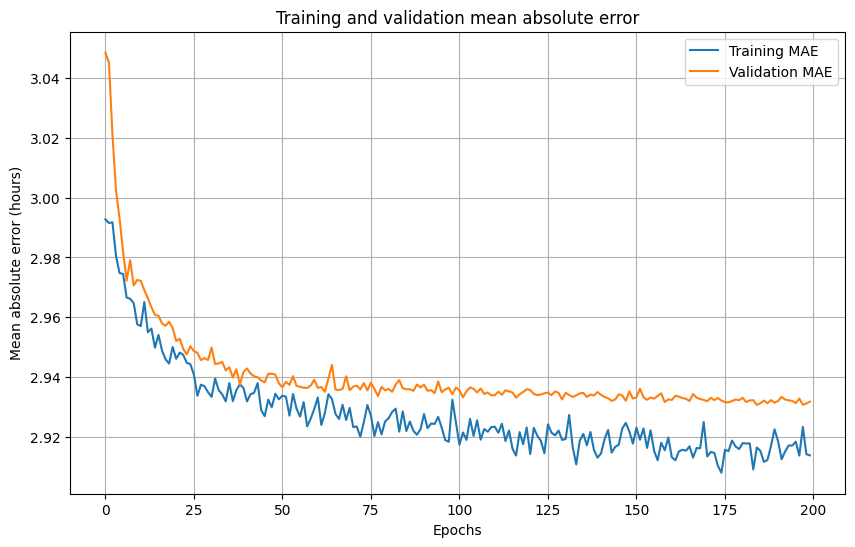

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
y_true: 2.8333333333333335, y_pred: 2.7076053619384766, linear_diff: 0.12572797139485692, circular_error: 0.12572797139485692
y_true: 10.066666666666666, y_pred: 9.86507511138916, linear_diff: 0.20159155527750627, circular_error: 0.20159155527750627
y_true: 10.3, y_pred: 9.981548309326172, linear_diff: 0.31845169067382884, circular_error: 0.31845169067382884
y_true: 6.9, y_pred: 7.066770553588867, linear_diff: 0.16677055358886683, circular_error: 0.16677055358886683
y_true: 10.966666666666667, y_pred: 10.890603065490723, linear_diff: 0.07606360117594413, circular_error: 0.07606360117594413
y_true: 1.95, y_pred: 1.9043951034545898, linear_diff: 0.04560489654541011, circular_error: 0.04560489654541011
y_true: 3.35, y_pred: 3.762843370437622, linear_diff: 0.412843370437622, circular_error: 0.412843370437622
y_true: 11.15, y_pred: 11.179094314575195, linear_diff: 0.029094314575194957, circular_error: 0.029094314575194957
y_true: 5.05, y_pred: 4.464166

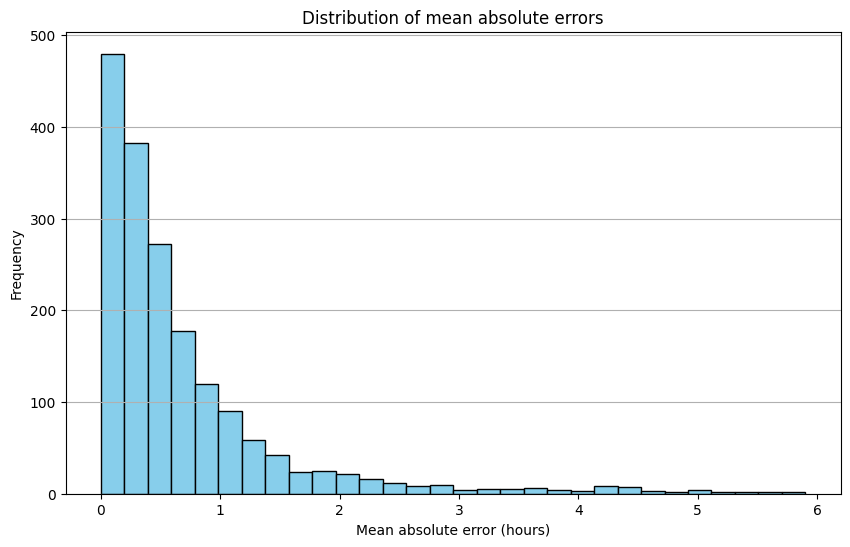

Mean Error: 0 hours and 41 minutes
Median Error: 0 hours and 25 minutes
Max Error: 5 hours and 54 minutes


In [7]:
def create_cnn(image_length, data, labels):    
    tf.keras.backend.clear_session()
    gc.collect()
    data_train, labels_train, data_test, labels_test, data_val, labels_val = preprocess_data(data, labels)

    # CNN for time components (regression)
    model = Sequential([
        # Layer 0
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_length, image_length, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        # Layer 1
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # Layer 2
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        # Layer 3
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=1e-4)
    
    model.summary() 

    model.compile(optimizer=optimizer, loss=common_sense_loss, metrics=[common_sense_metric])


    history = model.fit(
        data_train, labels_train,
        epochs=200,
        batch_size=32,
        validation_data=(data_val, labels_val)
    )

    results = model.evaluate(data_test, labels_test)

    return model, history, results, data_test, labels_test


def run(image_size=75):
    if image_size == 75: 
        data = np.load('../clocks_small/images.npy')
        labels = np.load('../clocks_small/labels.npy')
    elif image_size == 150:
        data = np.load('../clocks_large/images.npy')
        labels = np.load('../clocks_large/labels.npy')

    model, history, results, data_test, labels_test = create_cnn(image_size, data, labels)

    plot_training_validation_mae(history)
    plot_error_distribution(labels_test, model.predict(data_test))


run(75)